In [1]:
from __future__ import division
import time
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
from PIL import Image
from scipy.misc import toimage
from cs231n.data_utils import load_CIFAR10



import os.path
import os
from tensorflow.python.framework import ops

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test

print('Reading the data')
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Reading the data
Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [3]:
from lasso_codes.lasso import lasso_fista
#from lasso_codes.lasso import lasso_fista_col
from lasso_codes.lasso import compute_lasso_grad
#from lasso_codes.lasso import compute_lasso_grad_col2


In [4]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False, X_val=None,y_val=None):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [loss_val,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    total_correct=[]
    total_loss=[]
    total_loss_val=[]
    total_correct_val=[]
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct.append(correct/Xd.shape[0])
        total_loss.append(np.sum(losses)/Xd.shape[0])
        if training:
            print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss[-1],total_correct[-1],e+1))
            [total_loss_tmp, total_correct_tmp]=run_model(session,predict,loss_val,X_val,y_val,1,batch_size)
            total_loss_val.append(total_loss_tmp[-1])
            total_correct_val.append(total_correct_tmp[-1])
        else:
            print("(Validation) Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss[-1],total_correct[-1],e+1))
            
        
        if plot_losses:
            f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(12,4))

            ax1.plot(losses)
            ax1.grid(True)
            ax1.set_title('Epoch {} Loss'.format(e+1))
            ax1.set_xlabel('minibatch number')
            ax1.set_ylabel('minibatch loss')
            
            ax2.plot(list(range(1,len(total_loss)+1)), total_loss, list(range(1,len(total_loss)+1)), total_loss_val)
            ax2.grid(True)
            ax2.set_title('Epoch {} Loss'.format(e+1))
            ax2.set_xlabel('epoch')
            ax2.set_ylabel('epoch loss')
            ax2.legend(['Training','Validation'],loc="upper right")
            
            ax3.plot(list(range(1,len(total_loss)+1)), total_correct, list(range(1,len(total_loss)+1)), total_correct_val)
            ax3.grid(True)
            ax3.set_title('Epoch {} Accuracy'.format(e+1))
            ax3.set_xlabel('epoch')
            ax3.set_ylabel('epoch accuracy')
            ax3.legend(['Training','Validation'],loc="upper left")
            
            f.tight_layout()
            plt.show()
            
    if training:
        return total_loss,total_correct, total_loss_val, total_correct_val
    else:
        return total_loss,total_correct

In [5]:
def simple_model(X,y,is_training):
    padding='SAME'
    ksizes=[1,3,3,1]
    strides=[1,1,1,1]
    rates=[1,1,1,1]
    dims=[25,32,32,3]
    lambda1=0.01
    bsize=dims[0]
    
    @ops.RegisterGradient("LassoFistaGrad")
    def _lasso_fista_identity_grad(op, grad):

        D = op.inputs[0]
        X = op.inputs[1]
        lambda1=op.inputs[2]
        A = op.inputs[3]

        [lambda_grad, X_grad, D_grad]= compute_lasso_grad(X=X, A=A, D=D, lambda1=lambda1, grad_output=grad,
                                                        ksizes=ksizes, strides=strides, rates=rates,
                                                          padding=padding, params=dims,NonNeg=True)

        lambda_grad=tf.expand_dims(lambda_grad,0)
        A_grad=grad
        
        lambda_grad=None

        return[D_grad, X_grad, lambda_grad, A_grad,None,None,None,None, None]
    
    
    g = tf.get_default_graph()
    with g.gradient_override_map({'LassoFista': 'LassoFistaGrad'}):    
        _module=tf.load_op_library('lasso_codes/lasso_fista.so') #tf.sysconfig.get_lib()+

        D1=tf.get_variable("Dict1", shape=[27,50])
        #lambda1=tf.get_variable("lambda1", shape=[1])
        
        A1_tmp= lasso_fista(Dict=D1,
                 input=X,
                 lambda1=lambda1,
                 ksizes=ksizes,
                 strides=strides,
                 rates=rates,
                 padding=padding,
                 maxItr=500,
                 NonNeg=True,
                 debug=False,
                 name='lasso')
      
        if (padding=='VALID'):
            pad=0
        else:
            pad=1
        
        A_n=_module.lasso_fista(D1, X, lambda1, A1_tmp, ksizes, strides, rates, pad, dims)
        A1= A_n + tf.stop_gradient(A1_tmp-A_n)
    
    A1_dense=tf.reshape(A1,[bsize,-1])
    #print(A1_dense)
    W=tf.get_variable("Wclass", shape=[10,(32*32*50)])
    #W=np.random.rand(10, A1_dense.shape[1])
    y_out=tf.matmul(a=A1_dense, b=W, transpose_a=False, transpose_b=True)



    #grad_D = tf.gradients(loss, D1)
    #grad_X = tf.gradients(loss, X)
    #grad_lambda1 = tf.gradients(loss, lambda1)
    #y_out
    return(y_out)

In [6]:
# Define the Graph
tf.reset_default_graph()
is_training = tf.placeholder(tf.bool)
X= tf.placeholder(tf.float32, [None,32,32,3])
y= tf.placeholder(tf.int64,[None])
y_out=simple_model(X,y,is_training)

In [7]:
total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,10),logits=y_out)
#mean_loss = tf.reduce_mean(total_loss) + tf.add_n(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
mean_loss = tf.reduce_mean(total_loss)

# define our optimizer
optimizer = tf.train.AdamOptimizer(1e-5) # select optimizer and set learning rate

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

#y_onehot=tf.one_hot(y, 10)
#y_onehot=tf.cast(y_onehot,tf.float32)
#err=y_onehot-y_out
#loss=tf.norm(err,2)

Training
Iteration 0: with minibatch training loss = 361 and accuracy of 0
Iteration 100: with minibatch training loss = 188 and accuracy of 0.12
Iteration 200: with minibatch training loss = 158 and accuracy of 0.12
Iteration 300: with minibatch training loss = 124 and accuracy of 0.16
Iteration 400: with minibatch training loss = 69.2 and accuracy of 0.28
Iteration 500: with minibatch training loss = 91.5 and accuracy of 0.16
Iteration 600: with minibatch training loss = 81.9 and accuracy of 0.32
Iteration 700: with minibatch training loss = 63 and accuracy of 0.36
Iteration 800: with minibatch training loss = 76 and accuracy of 0.24
Iteration 900: with minibatch training loss = 75.4 and accuracy of 0.2
Iteration 1000: with minibatch training loss = 76 and accuracy of 0.28
Iteration 1100: with minibatch training loss = 68.9 and accuracy of 0.24
Iteration 1200: with minibatch training loss = 55 and accuracy of 0.24
Iteration 1300: with minibatch training loss = 76.2 and accuracy of 0.

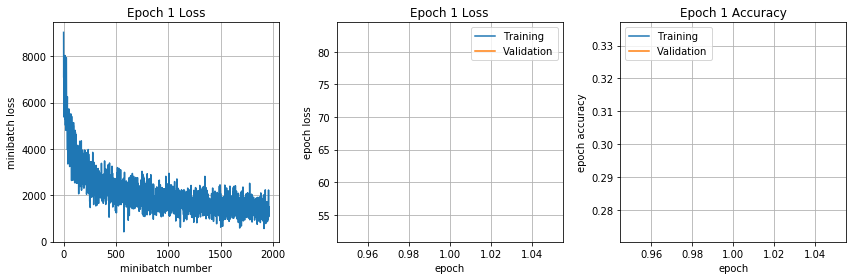

Iteration 2000: with minibatch training loss = 66.8 and accuracy of 0.36
Iteration 2100: with minibatch training loss = 52.6 and accuracy of 0.32
Iteration 2200: with minibatch training loss = 75.1 and accuracy of 0.24
Iteration 2300: with minibatch training loss = 63.3 and accuracy of 0.24
Iteration 2400: with minibatch training loss = 40.9 and accuracy of 0.36
Iteration 2500: with minibatch training loss = 44.6 and accuracy of 0.28
Iteration 2600: with minibatch training loss = 40.2 and accuracy of 0.36
Iteration 2700: with minibatch training loss = 53.2 and accuracy of 0.32
Iteration 2800: with minibatch training loss = 46.9 and accuracy of 0.36
Iteration 2900: with minibatch training loss = 48.9 and accuracy of 0.4
Iteration 3000: with minibatch training loss = 53.3 and accuracy of 0.4
Iteration 3100: with minibatch training loss = 38.2 and accuracy of 0.28
Iteration 3200: with minibatch training loss = 42.9 and accuracy of 0.28
Iteration 3300: with minibatch training loss = 58 and

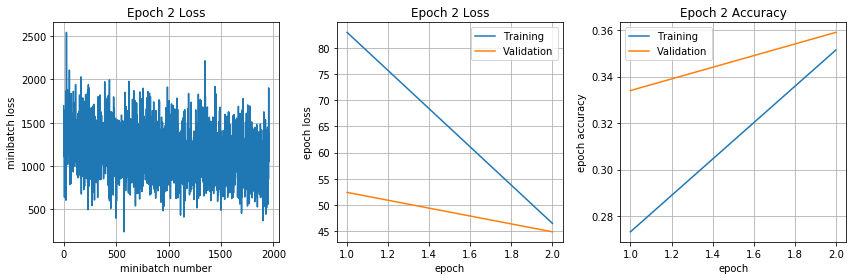

Iteration 4000: with minibatch training loss = 49.2 and accuracy of 0.4
Iteration 4100: with minibatch training loss = 31.2 and accuracy of 0.52
Iteration 4200: with minibatch training loss = 30.1 and accuracy of 0.56
Iteration 4300: with minibatch training loss = 27.7 and accuracy of 0.64
Iteration 4400: with minibatch training loss = 33.5 and accuracy of 0.32
Iteration 4500: with minibatch training loss = 46.4 and accuracy of 0.36
Iteration 4600: with minibatch training loss = 56.5 and accuracy of 0.2
Iteration 4700: with minibatch training loss = 40.5 and accuracy of 0.44
Iteration 4800: with minibatch training loss = 27.6 and accuracy of 0.56
Iteration 4900: with minibatch training loss = 41.4 and accuracy of 0.28
Iteration 5000: with minibatch training loss = 38.7 and accuracy of 0.32
Iteration 5100: with minibatch training loss = 37.7 and accuracy of 0.32
Iteration 5200: with minibatch training loss = 38.8 and accuracy of 0.44
Iteration 5300: with minibatch training loss = 22.4 a

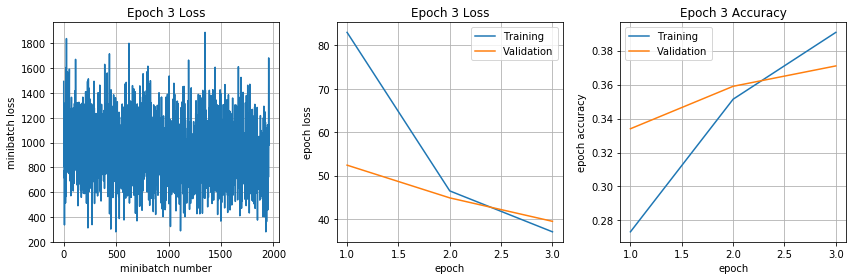

Iteration 5900: with minibatch training loss = 44.7 and accuracy of 0.32
Iteration 6000: with minibatch training loss = 24.7 and accuracy of 0.6
Iteration 6100: with minibatch training loss = 38.7 and accuracy of 0.4
Iteration 6200: with minibatch training loss = 32.3 and accuracy of 0.36
Iteration 6300: with minibatch training loss = 35.3 and accuracy of 0.32
Iteration 6400: with minibatch training loss = 31.3 and accuracy of 0.4
Iteration 6500: with minibatch training loss = 25.8 and accuracy of 0.48
Iteration 6600: with minibatch training loss = 31 and accuracy of 0.52
Iteration 6700: with minibatch training loss = 16.7 and accuracy of 0.56
Iteration 6800: with minibatch training loss = 36.9 and accuracy of 0.24
Iteration 6900: with minibatch training loss = 33.4 and accuracy of 0.48
Iteration 7000: with minibatch training loss = 31.5 and accuracy of 0.44
Iteration 7100: with minibatch training loss = 25.1 and accuracy of 0.44
Iteration 7200: with minibatch training loss = 35.2 and 

In [ ]:
num_train = 1000
X_train_small= tf.to_float(X_train[:num_train], name='ToFloat')
y_train_small= tf.to_float(y_train[:num_train], name='ToFloat')

sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')


[loss,correct, loss_val,correct_val]=run_model(session=sess, predict=y_out, loss_val=mean_loss, Xd=X_train, yd=y_train,
              epochs=50, batch_size=25, print_every=100,
              training=train_step, plot_losses=True, X_val=X_val,y_val=y_val)